In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from astropy import time as astropytime
from ctapipe.io import EventSource, EventSeeker
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from ctapipe.image import (
    tailcuts_clean,
    dilate,
    hillas_parameters,
    HillasParameterizationError,
)

In [3]:
lfns = [
    "/vo.cta.in2p3.fr/nectarcam/2024/20240910/NectarCAM.Run5661.0000.fits.fz",
    "/vo.cta.in2p3.fr/nectarcam/2024/20240910/NectarCAM.Run5661.0001.fits.fz",
    "/vo.cta.in2p3.fr/nectarcam/2024/20240910/NectarCAM.Run5661.0002.fits.fz",
    "/vo.cta.in2p3.fr/nectarcam/2024/20240910/NectarCAM.Run5661.0003.fits.fz",
    "/vo.cta.in2p3.fr/nectarcam/2024/20240910/NectarCAM.Run5661.0005.fits.fz"
    "/vo.cta.in2p3.fr/nectarcam/2024/20240910/NectarCAM.Run5661.0006.fits.fz",
    "/vo.cta.in2p3.fr/nectarcam/2024/20240910/NectarCAM.Run5661.0007.fits.fz",
]
cmap = "gnuplot2"

In [4]:
import os

tmpdir = f"/tmp/{os.environ['USER']}/scratch"
if not os.path.isdir(tmpdir):
    print(f"{tmpdir} does not exist yet, I will create it for you")
    os.makedirs(tmpdir)

/tmp/amikhno/scratch does not exist yet, I will create it for you


In [5]:
import DIRAC
import ZEO
from astropy.io import fits
from DIRAC.Interfaces.API.Dirac import Dirac
from glob import glob
from nectarchain.dqm.db_utils import DQMDB

dirac = Dirac()

dirac.getFile(lfn=lfns, destDir=tmpdir, printOutput=True)

2025-01-17 10:32:45 UTC Framework/GFAL2_HTTPSStorage/GFAL2_StorageBase._getSingleFile INFO: Trying to download https://eos.grif.fr:11000/eos/grif/cta/vo.cta.in2p3.fr/nectarcam/2024/20240910/NectarCAM.Run5661.0002.fits.fz to /tmp/amikhno/scratch/NectarCAM.Run5661.0002.fits.fz
2025-01-17 10:39:54 UTC Framework/GFAL2_HTTPSStorage/GFAL2_StorageBase._getSingleFile INFO: Trying to download https://eos.grif.fr:11000/eos/grif/cta/vo.cta.in2p3.fr/nectarcam/2024/20240910/NectarCAM.Run5661.0003.fits.fz to /tmp/amikhno/scratch/NectarCAM.Run5661.0003.fits.fz
2025-01-17 10:43:36 UTC Framework/GFAL2_SRM2Storage/GFAL2_StorageBase._getSingleFile INFO: Trying to download srm://ccsrm02.in2p3.fr:8443/srm/managerv2?SFN=/pnfs/in2p3.fr/data/vo.cta.in2p3.fr/nectarcam/2024/20240910/NectarCAM.Run5661.0007.fits.fz to /tmp/amikhno/scratch/NectarCAM.Run5661.0007.fits.fz
2025-01-17 10:43:36 UTC Framework/GFAL2_HTTPSStorage/GFAL2_StorageBase._getSingleFile INFO: Trying to download https://eos.grif.fr:11000/eos/grif/

{'OK': False,
 'Errno': 0,
 'Message': {'Successful': {'/vo.cta.in2p3.fr/nectarcam/2024/20240910/NectarCAM.Run5661.0002.fits.fz': '/tmp/amikhno/scratch/NectarCAM.Run5661.0002.fits.fz',
   '/vo.cta.in2p3.fr/nectarcam/2024/20240910/NectarCAM.Run5661.0003.fits.fz': '/tmp/amikhno/scratch/NectarCAM.Run5661.0003.fits.fz',
   '/vo.cta.in2p3.fr/nectarcam/2024/20240910/NectarCAM.Run5661.0007.fits.fz': '/tmp/amikhno/scratch/NectarCAM.Run5661.0007.fits.fz',
   '/vo.cta.in2p3.fr/nectarcam/2024/20240910/NectarCAM.Run5661.0000.fits.fz': '/tmp/amikhno/scratch/NectarCAM.Run5661.0000.fits.fz',
   '/vo.cta.in2p3.fr/nectarcam/2024/20240910/NectarCAM.Run5661.0001.fits.fz': '/tmp/amikhno/scratch/NectarCAM.Run5661.0001.fits.fz'},
  'Failed': {'/vo.cta.in2p3.fr/nectarcam/2024/20240910/NectarCAM.Run5661.0005.fits.fz/vo.cta.in2p3.fr/nectarcam/2024/20240910/NectarCAM.Run5661.0006.fits.fz': 'No such file or directory'}},
 'CallStack': ['  File "<frozen runpy>", line 198, in _run_module_as_main\n',
  '  File "<fr

In [6]:
pwd = glob(f"{tmpdir}/NectarCAM.*.fits.fz")
print(pwd)

['/tmp/amikhno/scratch/NectarCAM.Run5661.0000.fits.fz', '/tmp/amikhno/scratch/NectarCAM.Run5661.0003.fits.fz', '/tmp/amikhno/scratch/NectarCAM.Run5661.0007.fits.fz', '/tmp/amikhno/scratch/NectarCAM.Run5661.0002.fits.fz', '/tmp/amikhno/scratch/NectarCAM.Run5661.0001.fits.fz']


In [8]:
source = EventSource.from_url(input_url=pwd[0], max_events=100)

for event in source:
    print(event.index.event_id, event.trigger.event_type, event.trigger.time)

2025-01-17 10:51:51,036 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/calibration is missing column time_correction for field time_correction of container <class 'ctapipe.containers.WaveformCalibrationContainer'>. It will be skipped.
2025-01-17 10:51:51,037 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/calibration is missing column n_pe for field n_pe of container <class 'ctapipe.containers.WaveformCalibrationContainer'>. It will be skipped.
2025-01-17 10:51:51,042 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/flatfield is missing column charge_mean for field charge_mean of container <class 'ctapipe.containers.FlatFieldContainer'>. It will be skipped.
2025-01-17 10:51:51,042 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/flatfield is missing column charge_median for field charge_median of container <class 'ctapipe.containers.FlatFieldContainer'>. It will be skipped.
2025-01-17 10:51:51,043 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel

4 EventType.SKY_PEDESTAL 1726006018.3802218
8 EventType.SKY_PEDESTAL 1726006018.5802224
12 EventType.SKY_PEDESTAL 1726006018.9802232
16 EventType.SUBARRAY 1726006019.264819
20 EventType.SUBARRAY 1726006019.507737
24 EventType.SKY_PEDESTAL 1726006019.980225
28 EventType.SKY_PEDESTAL 1726006020.380226
32 EventType.SKY_PEDESTAL 1726006020.7802267
36 EventType.SKY_PEDESTAL 1726006021.3802278
40 EventType.SKY_PEDESTAL 1726006021.7802286
44 EventType.SKY_PEDESTAL 1726006022.38023
48 EventType.SKY_PEDESTAL 1726006022.7802308
52 EventType.SKY_PEDESTAL 1726006023.3802319
56 EventType.FLATFIELD 1726006023.7363458
60 EventType.SUBARRAY 1726006024.0967457
64 EventType.SUBARRAY 1726006024.4700494
68 EventType.SKY_PEDESTAL 1726006024.980235
72 EventType.SKY_PEDESTAL 1726006025.1802354
76 EventType.FLATFIELD 1726006025.4031284
80 EventType.SKY_PEDESTAL 1726006025.980237
84 EventType.SUBARRAY 1726006026.204855
88 EventType.FLATFIELD 1726006026.7365544
92 EventType.FLATFIELD 1726006027.0699108
96 Event

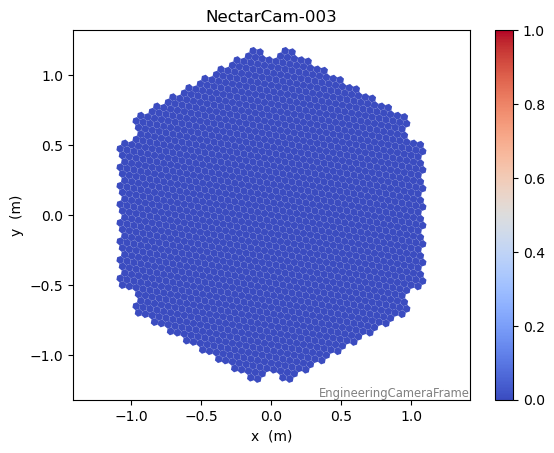

In [11]:
from ctapipe.coordinates import EngineeringCameraFrame
from ctapipe.io import EventSource, EventSeeker
from ctapipe.instrument import CameraGeometry

camera = CameraGeometry.from_name("NectarCam-003").transform_to(
    EngineeringCameraFrame()
)
disp = CameraDisplay(geometry=camera)

chan = 0
disp.image = event.mon.tel[0].pixel_status.hardware_failing_pixels[chan]
disp.set_limits_minmax(0, 1)
disp.cmap = plt.cm.coolwarm
disp.add_colorbar()

In [12]:
from ctapipe.image.extractor import NeighborPeakWindowSum

extractor = NeighborPeakWindowSum(source.subarray)

In [13]:
n_pixels = 1855
broken_pixels = np.zeros(n_pixels, dtype=bool)

In [17]:
waveforms = event.r1.tel[0].waveform[0, np.arange(n_pixels), :]
n_pixels = waveforms.shape[1]

charge = extractor(waveforms, 0, selected_gain_channel=0, broken_pixels=broken_pixels)

In [18]:
charge

ctapipe.containers.DL1CameraContainer:
                         image: Numpy array of camera image, after waveform
                                extraction.Shape: (n_pixel) with default None as
                                a 1-D array with dtype float32
                     peak_time: Numpy array containing position of the peak of
                                the pulse as determined by the extractor. Shape:
                                (n_pixel, ) with default None as a 1-D array
                                with dtype float32
                    image_mask: Boolean numpy array where True means the pixel
                                has passed cleaning. Shape: (n_pixel, ) with
                                default None as a 1-D array with dtype bool
                      is_valid: True if image extraction succeeded, False if
                                failed or in the case of TwoPass methods, that
                                the first pass only was returned.

In [19]:
source = EventSource.from_url(input_url=pwd[0])
import pandas as pd

charge_df = pd.DataFrame()
pixel_id = 0  # look at a particular pixel
times = []
charges = []
for event in source:
    charge = extractor(
        event.r1.tel[0].waveform[0, np.arange(n_pixels), :],
        0,
        selected_gain_channel=0,
        broken_pixels=broken_pixels,
    )  # Extract signal (charge)
    time = event.trigger.time.value + charge.peak_time[pixel_id]
    print(time)
    times.append(time)
    charge_pix = charge.image[pixel_id]
    print(charge_pix)
    charges.append(charge_pix)
    print(event.index.event_id)

2025-01-17 12:49:41,645 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/calibration is missing column time_correction for field time_correction of container <class 'ctapipe.containers.WaveformCalibrationContainer'>. It will be skipped.
2025-01-17 12:49:41,645 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/calibration is missing column n_pe for field n_pe of container <class 'ctapipe.containers.WaveformCalibrationContainer'>. It will be skipped.
2025-01-17 12:49:41,652 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/flatfield is missing column charge_mean for field charge_mean of container <class 'ctapipe.containers.FlatFieldContainer'>. It will be skipped.
2025-01-17 12:49:41,653 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/flatfield is missing column charge_median for field charge_median of container <class 'ctapipe.containers.FlatFieldContainer'>. It will be skipped.
2025-01-17 12:49:41,653 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel

1726006023.6590328
0.5266921
4
1726006030.1801388
0.6008423
8
1726006056.908362
0.43891427
12
1726006072.033076
0.29159078
16
1726006072.1622932
0.5956568
20
1726006067.426518
0.15932278
24
1726006043.0611875
0.6104117
28
1726006074.3497496
0.19972967
32
1726006076.1655443
0.287257
36
1726006038.7659044
0.49144572
40
1726006050.2795906
0.60685456
44
1726006056.1190941
0.6039737
48
1726006074.522974
0.41579244
52
1726006054.2841153
124.33406
56
1726006041.4351685
0.40201452
60
1726006051.3516412
0.62799734
64
1726006081.9912214
0.389915
68
1726006048.2402387
0.53886676
72
1726006079.4031284
-2.3954535
76
1726006028.9084847
0.6741659
80
1726006059.8756046
0.24624892
84
1726006064.6186993
5.4477124
88
1726006057.0909774
95.066216
92
1726006040.8015566
0.528596
96
1726006035.0079377
0.696436
100
1726006034.6048415
0.696436
104
1726006055.7683954
0.35970378
108
1726006070.8717875
0.36644244
112
1726006059.00676
101.23696
116
1726006086.505567
0.4793462
120
1726006057.4564695
0.5743386
124
1

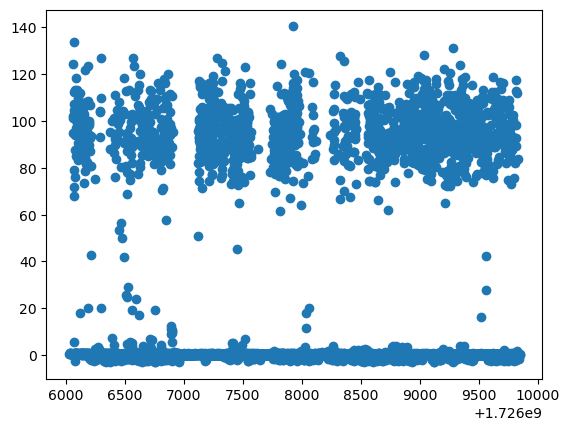

In [20]:
charge_df["time"] = times
charge_df["charge"] = charges
plt.scatter(charge_df["time"], charge_df["charge"])

In [21]:
from ctapipe.containers import EventType

source = EventSource.from_url(input_url=pwd[0])
channel = [0, 1]

tel_id = 0

# read first pedestal event

for i, event in enumerate(source):
    if event.trigger.event_type == EventType.SKY_PEDESTAL:
        break

2025-01-17 12:50:27,682 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/calibration is missing column time_correction for field time_correction of container <class 'ctapipe.containers.WaveformCalibrationContainer'>. It will be skipped.
2025-01-17 12:50:27,682 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/calibration is missing column n_pe for field n_pe of container <class 'ctapipe.containers.WaveformCalibrationContainer'>. It will be skipped.
2025-01-17 12:50:27,687 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/flatfield is missing column charge_mean for field charge_mean of container <class 'ctapipe.containers.FlatFieldContainer'>. It will be skipped.
2025-01-17 12:50:27,687 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/flatfield is missing column charge_median for field charge_median of container <class 'ctapipe.containers.FlatFieldContainer'>. It will be skipped.
2025-01-17 12:50:27,688 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel

In [22]:
print(f"read event id: {event.index.event_id}, trigger {event.trigger.event_type}")

read event id: 4, trigger EventType.SKY_PEDESTAL


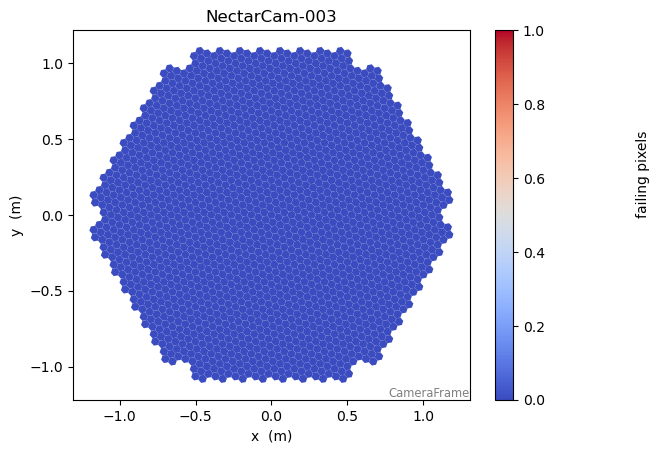

In [23]:
disp = CameraDisplay(source.subarray.tel[0].camera.geometry)

chan = 0
disp.image = event.mon.tel[tel_id].pixel_status.hardware_failing_pixels[chan]
disp.set_limits_minmax(0, 1)
disp.cmap = plt.cm.coolwarm
disp.axes.text(2.4, 0, "failing pixels", rotation=90)
disp.add_colorbar()

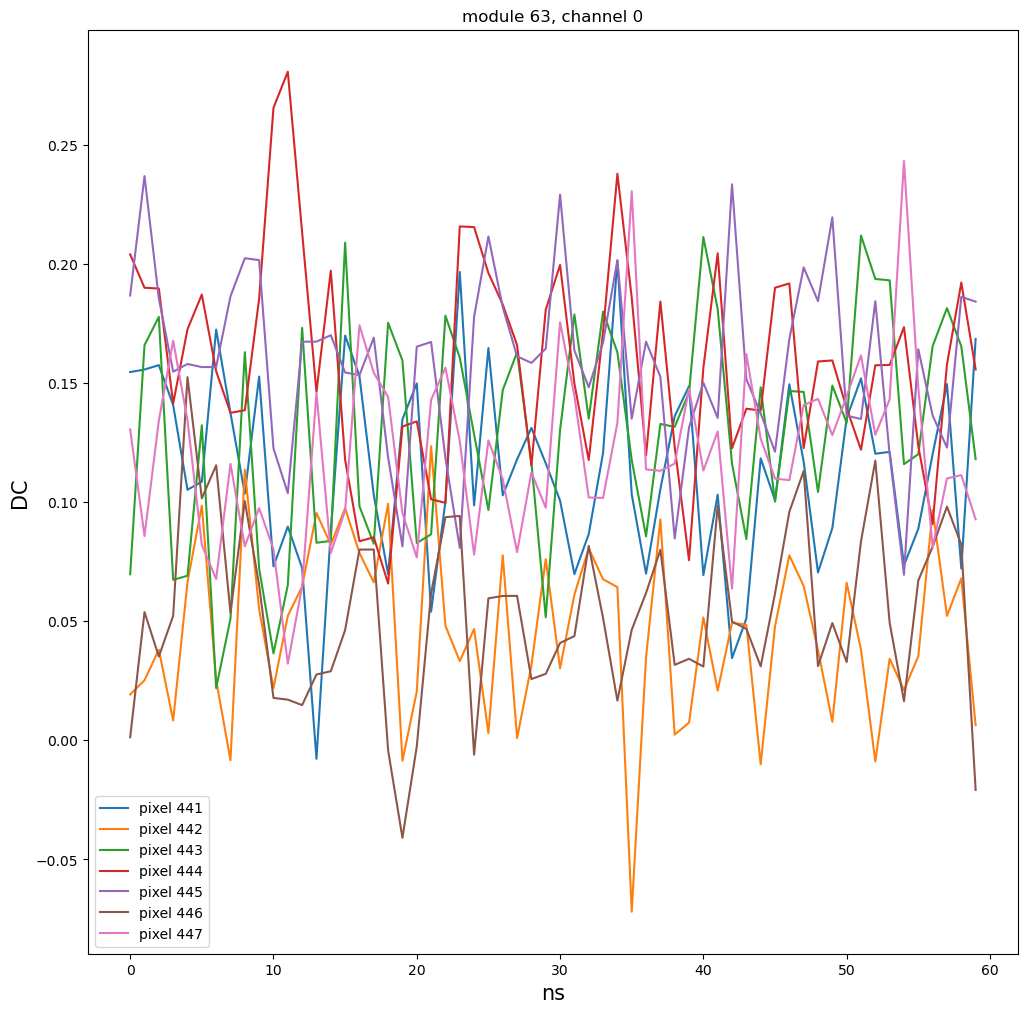

In [24]:
def view_waveform(chan=0, pix_id=6):
    waveform = event.r1.tel[tel_id].waveform
    plt.plot(waveform[chan, pix_id], label=f"pixel {pix_id}")

    plt.title(
        f"module {module}, channel {channel[chan]}",
    )
    max_now = waveform[chan, pix_id].max()
    min_now = waveform[chan, pix_id].min()
    plt.legend()
    plt.ylabel("DC", fontsize=15)
    plt.xlabel("ns", fontsize=15)


# module number

module = 63
module_rank = np.where(event.nectarcam.tel[0].svc.module_ids == module)

# ids of pixel in module
pixels_mod = event.nectarcam.tel[0].svc.pixel_ids[
    module_rank[0][0] * 7 : module_rank[0][0] * 7 + 7
]
#
# channel
chan = 0
# ids of pixel in module
# pixels_mod=event.nectarcam.tel[0].svc.pixel_ids[module*7:module*7+7]

fig = plt.figure(num=0, figsize=(12, 12))

for i, pix in enumerate(pixels_mod):
    view_waveform(chan=chan, pix_id=pix)

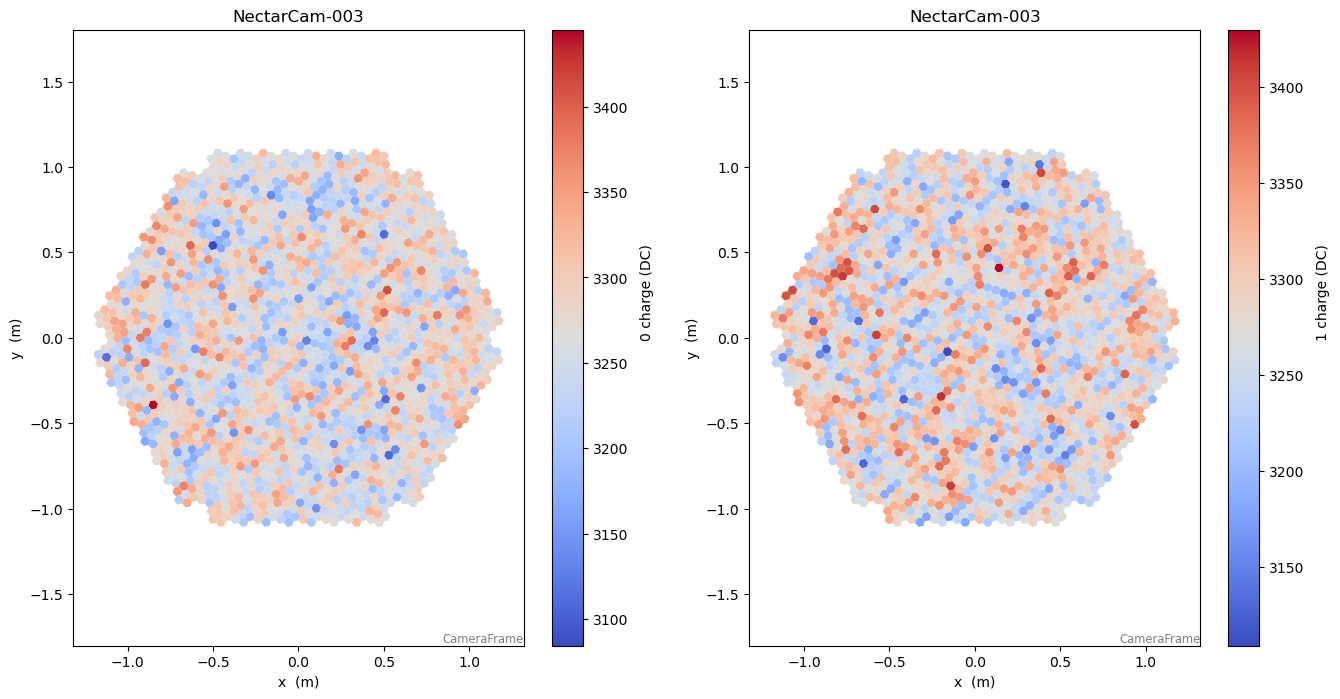

In [25]:
# integrate the charge on 12 ns around the peak value
from traitlets.config.loader import Config
from ctapipe.image.extractor import FixedWindowSum

config = Config({"FixedWindowSum": {"window_width": 12}})
# integrator = LocalPeakWindowSum(config=config)
integrator = FixedWindowSum(source.subarray, config=config)


waveform = event.r0.tel[0].waveform
image = integrator(waveform, 0, selected_gain_channel=0, broken_pixels=broken_pixels)

fig = plt.figure(figsize=(16, 8))
for chan in np.arange(2):
    ax = plt.subplot(1, 2, chan + 1)

    disp = CameraDisplay(source.subarray.tel[0].camera.geometry)
    disp.image = image.image[chan]
    # disp.set_limits_minmax(0,200)
    disp.cmap = plt.cm.coolwarm
    disp.axes.text(2.0, 0, f"{channel[chan]} charge (DC)", rotation=90)
    disp.add_colorbar()

    disp.update()

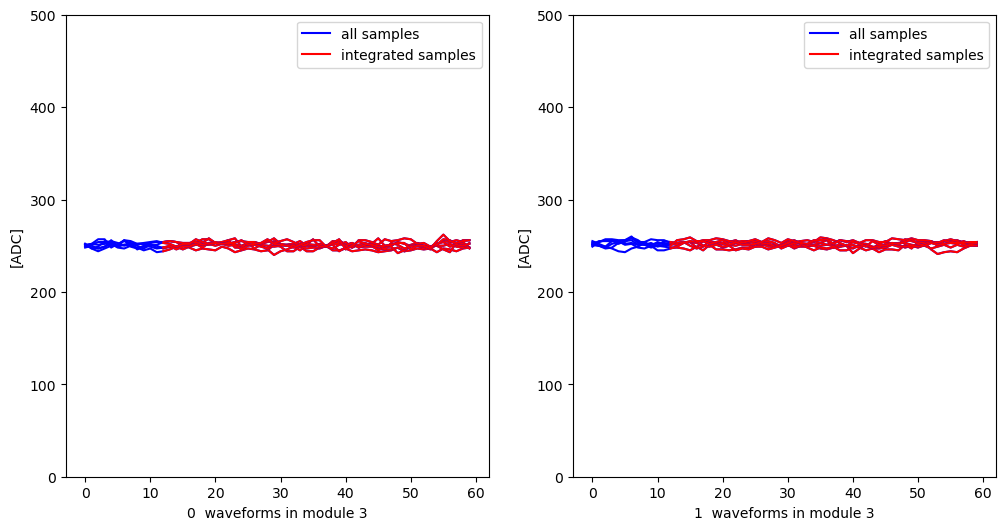

In [26]:
fig = plt.figure(0, figsize=(12, 6))

# consider only 36 samples
samples = np.arange(0, 60)

# chose the module
mod = 3
window_start = 12

# find pixel index in module
pix_in_mod = event.nectarcam.tel[0].svc.pixel_ids[mod * 7 : mod * 7 + 7]

for chan in np.arange(2):
    plt.subplot(1, 2, chan + 1)

    for i, pix in enumerate(pix_in_mod):
        # samples used to calculate the charge
        start = 12
        stop = 60
        used_samples = np.arange(start, stop)
        used = waveform[chan, pix, start:stop]

        plt.plot(waveform[chan, pix], color="b", label="all samples")
        plt.plot(used_samples, used, color="r", label="integrated samples")

        if i == 0:
            plt.legend()
        plt.ylabel("[ADC]")
        plt.xlabel(f"{channel[chan]}  waveforms in module {mod}")
        plt.ylim(0, 500)

In [27]:
source = EventSource.from_url(input_url=pwd[0])

for event in source:
    print("Id: {},  Telescopes: {}".format(event.count, len(event.r0.tel)))

2025-01-17 12:53:33,114 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/calibration is missing column time_correction for field time_correction of container <class 'ctapipe.containers.WaveformCalibrationContainer'>. It will be skipped.
2025-01-17 12:53:33,115 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/calibration is missing column n_pe for field n_pe of container <class 'ctapipe.containers.WaveformCalibrationContainer'>. It will be skipped.
2025-01-17 12:53:33,119 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/flatfield is missing column charge_mean for field charge_mean of container <class 'ctapipe.containers.FlatFieldContainer'>. It will be skipped.
2025-01-17 12:53:33,119 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/flatfield is missing column charge_median for field charge_median of container <class 'ctapipe.containers.FlatFieldContainer'>. It will be skipped.
2025-01-17 12:53:33,120 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel

Id: 0,  Telescopes: 1
Id: 1,  Telescopes: 1
Id: 2,  Telescopes: 1
Id: 3,  Telescopes: 1
Id: 4,  Telescopes: 1
Id: 5,  Telescopes: 1
Id: 6,  Telescopes: 1
Id: 7,  Telescopes: 1
Id: 8,  Telescopes: 1
Id: 9,  Telescopes: 1
Id: 10,  Telescopes: 1
Id: 11,  Telescopes: 1
Id: 12,  Telescopes: 1
Id: 13,  Telescopes: 1
Id: 14,  Telescopes: 1
Id: 15,  Telescopes: 1
Id: 16,  Telescopes: 1
Id: 17,  Telescopes: 1
Id: 18,  Telescopes: 1
Id: 19,  Telescopes: 1
Id: 20,  Telescopes: 1
Id: 21,  Telescopes: 1
Id: 22,  Telescopes: 1
Id: 23,  Telescopes: 1
Id: 24,  Telescopes: 1
Id: 25,  Telescopes: 1
Id: 26,  Telescopes: 1
Id: 27,  Telescopes: 1
Id: 28,  Telescopes: 1
Id: 29,  Telescopes: 1
Id: 30,  Telescopes: 1
Id: 31,  Telescopes: 1
Id: 32,  Telescopes: 1
Id: 33,  Telescopes: 1
Id: 34,  Telescopes: 1
Id: 35,  Telescopes: 1
Id: 36,  Telescopes: 1
Id: 37,  Telescopes: 1
Id: 38,  Telescopes: 1
Id: 39,  Telescopes: 1
Id: 40,  Telescopes: 1
Id: 41,  Telescopes: 1
Id: 42,  Telescopes: 1
Id: 43,  Telescopes: 

In [8]:
source.subarray.camera_types

(CameraDescription(name=NectarCam, geometry=NectarCam-003, readout=NectarCam),)

In [28]:
len(event.r0.tel), len(event.r1.tel)

(1, 1)

In [29]:
from ctapipe.calib import CameraCalibrator

calibrator = CameraCalibrator(subarray=source.subarray)

In [30]:
calibrator(event)

ValueError: too many values to unpack (expected 2)

In [ ]:
event.mon.tel[tel_id].pedestal

In [ ]:
fig = plt.figure(11, figsize=(16, 5))
# mask=  np.logical_or(ped_data.charge_median_outliers, status_data.hardware_failing_pixels)

image = ped_data.charge_median
# plt.savefig(f"std_{channel[chan]}.png")
chan = 0

ax = plt.subplot(1, 2, 1)
disp = CameraDisplay(source.subarray.tel[0].camera.geometry)
# disp.highlight_pixels(mask[chan])
disp.image = image[chan]
disp.cmap = plt.cm.coolwarm
disp.add_colorbar()
disp.axes.text(2.4, 0, "charge median", rotation=90)
ax = plt.subplot(1, 2, 2)

chan = 1

disp = CameraDisplay(source.subarray.tel[0].camera.geometry)
# disp.highlight_pixels(mask[chan])
disp.image = image[chan]
disp.cmap = plt.cm.coolwarm
disp.axes.text(2.4, 0, "charge median", rotation=90)
disp.add_colorbar()
# plt.savefig(f"Run{run}_pedestal_median_r1_over_camera.png")
# plot data
fig = plt.figure(10, figsize=(16, 5))


image = ped_data.charge_std
mask = np.logical_or(ped_data.charge_std_outliers, status_data.hardware_failing_pixels)
chan = 0
ax = plt.subplot(1, 2, 1)
disp = CameraDisplay(source.subarray.tel[0].camera.geometry)
# disp.highlight_pixels(mask[chan])
disp.image = image[chan]
disp.cmap = plt.cm.coolwarm
disp.axes.text(2.4, 0, "charge std", rotation=90)
disp.add_colorbar()

ax = plt.subplot(1, 2, 2)
chan = 1
disp = CameraDisplay(source.subarray.tel[0].camera.geometry)
# disp.highlight_pixels(mask[chan])
disp.image = image[chan]
disp.cmap = plt.cm.coolwarm
disp.add_colorbar()
disp.axes.text(2.4, 0, "charge std", rotation=90)
# plt.savefig(f"Run{run}_pedestal_std_r1_over_camera.png")
#
# plt.savefig(f"pedestal_median_r1.png")

In [ ]:
print(ped_data.charge_std_outliers)

In [ ]:
plt.pcolormesh(teldata.waveform[0])
plt.colorbar()
plt.ylim(700, 750)
plt.xlabel("sample number")
plt.ylabel("pixel_id")
print("waveform[0] is an array of shape (N_pix,N_slice) =", teldata.waveform[0].shape)

In [ ]:
trace = teldata.waveform[0][719]

plt.plot(trace, drawstyle="steps")

In [ ]:
for pix_id in range(718, 723):
    plt.plot(
        teldata.waveform[0][pix_id], label="pix {}".format(pix_id), drawstyle="steps"
    )

plt.legend()

In [ ]:
camgeom = source.subarray.tel[0].camera.geometry

In [ ]:
data = teldata.waveform[0]
peds = data[:, 10:20].mean(axis=1)
sums = data[:, 25:35].sum(axis=1) / (18)

In [ ]:
phist = plt.hist(peds, bins=50, range=[0, 150])

plt.title("Pedestal Distribution of all pixels for a single event")

In [ ]:
plt.plot(sums - peds)

plt.xlabel("pixel id")

plt.ylabel("Pedestal-subtracted Signal")

In [ ]:
# we can also subtract the pedestals from the traces themselves, which would be needed to compare peaks properly

for ii in range(300, 310):
    plt.plot(data[ii] - peds[ii], drawstyle="steps", label="pix{}".format(ii))

plt.legend()

In [ ]:
title = "CT24, run {} event {} ped-sub".format(event.index.obs_id, event.index.event_id)
disp = CameraDisplay(camgeom, title=title)
disp.image = sums - peds
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)  # autoscale

In [ ]:
?source

In [ ]:
event.trigger.time

## Look at waveform image for a particular event

In [ ]:
evt = seeker.get_event_index(25)
import time
from IPython import display

adcsum = evt.r0.tel[0].waveform[0].sum(axis=1)

camera = CameraGeometry.from_name("NectarCam-003")

for i in range(len(evt.r0.tel[0].waveform[0].T)):
    image = evt.r0.tel[0].waveform[0].T[i]
    plt.clf()

    fig = plt.figure(figsize=(13, 9))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    disp2 = CameraDisplay(
        geometry=camera, image=adcsum, ax=ax1, title="Sum ADC", cmap=cmap
    )
    # disp2.cmap = cmap
    # disp2.add_colorbar()

    disp = CameraDisplay(
        geometry=camera,
        image=image,
        ax=ax2,
        title="Waveform (ADC), T={} ns".format(i),
        cmap=cmap,
    )
    # disp.cmap = cmap
    disp.add_colorbar()

    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.2)

## Or look at an integrated charge image for a particular event

In [ ]:
evt = seeker.get_event_index(0)
image = evt.r0.tel[0].waveform.sum(axis=2)
disp = CameraDisplay(geometry=camera, image=image[0], cmap=cmap)

In [ ]:
run_start = astropytime.Time(evt.nectarcam.tel[0].svc.date, format="unix").iso
print("Run started at {}".format(run_start))

In [ ]:
evt.index.event_id

## Extract interleaved pedestals

In [ ]:
# Evaluate pedestal from interleaved pedestals from same input run
max_events = 500
read_ped = EventSource(input_url=path[0])
peds = []
for i, ev in enumerate(read_ped):
    if len(peds) > max_events:
        break
    if ev.trigger.event_type == 32:
        # print('Event {}, trigger type {}'.format(i,ev.r0.tel[0].trigger_type))
        wfs = ev.r0.tel[0].waveform
        wfs_hi = wfs[0].sum(axis=1)
        peds.append(wfs_hi)
peds = np.array(peds)
peds = peds.mean(axis=0)

In [ ]:
peds.shape

In [ ]:
disp = CameraDisplay(geometry=camera, image=peds, cmap=cmap)
disp.cmap = cmape
disp.add_colorbar()

In [ ]:
camera

In [ ]:
plt.plot(peds)

## Calibration

In [ ]:
adc_to_pe = 58.0
evt = next(iter(seeker))
print("Event {}, trigger type {}".format(evt.index.event_id, evt.trigger.event_type))
if evt.trigger.event_type == 1:
    raw = evt.r0.tel[0].waveform[0].sum(axis=1)
    charges = (raw - peds) / adc_to_pe
disp = CameraDisplay(geometry=camera, image=charges, cmap="gnuplot2")
disp.cmap = cmap
disp.add_colorbar()

# Comment: if this cell says that "charges" is not defined it's because the event type is not 1. Re-run it.

## Hillas cleaning

In [ ]:
cleanmask = tailcuts_clean(
    camera,
    charges,
    picture_thresh=10,
    boundary_thresh=5,
    min_number_picture_neighbors=3,
)
charges[~cleanmask] = 0
try:
    hillas_param = hillas_parameters(camera, charges)
    disp = CameraDisplay(geometry=camera, image=charges, cmap="gnuplot2")
    disp.cmap = cmap
    disp.add_colorbar()
    disp.overlay_moments(
        hillas_param,
        with_label=False,
        color="red",
        alpha=0.7,
        linewidth=2,
        linestyle="dashed",
    )
    disp.highlight_pixels(cleanmask, color="white", alpha=0.3, linewidth=2)
    print(hillas_param)
except HillasParameterizationError:
    pass
print("Cleaned image: charge = {} pe".format(charges.sum()))

## Loop over events

In [ ]:
import time
from IPython import display

for i, evt in enumerate(reader):
    if evt.trigger.event_type == 1:
        raw = evt.r0.tel[0].waveform[0].sum(axis=1)
        charges = (raw - peds) / adc_to_pe
        cleanmask = tailcuts_clean(
            camera,
            charges,
            picture_thresh=10,
            boundary_thresh=5,
            min_number_picture_neighbors=3,
        )
        charges[~cleanmask] = 0

        plt.clf()
        disp = CameraDisplay(geometry=camera, image=charges, cmap="gnuplot2")
        disp.cmap = cmap
        disp.add_colorbar()
        try:
            hillas_param = hillas_parameters(camera, charges)
            disp.overlay_moments(
                hillas_param,
                with_label=False,
                color="red",
                alpha=0.7,
                linewidth=2,
                linestyle="dashed",
            )
            disp.highlight_pixels(cleanmask, color="white", alpha=0.3, linewidth=2)
        except HillasParameterizationError:
            pass
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.2)